# Introduction

We obtain our data from Our World In Data: https://ourworldindata.org/coronavirus. Our three datasets pertain to worldwide Covid-19 cases and deaths, vaccinations, and variants. We perform a number of analyses predicting the number of covid cases and deaths via regressions (fixed-time point methods) and recurrent neural networks (time-dependent methods). 

### Initial Data Cleaning

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#csv files were pulled at 12:30pm 11/21/2021

#set if needed
personal_path = ''

#get paths to csv files in google drive
path_vaccine = os.path.join(personal_path, "Data/vaccinations.csv")
path_covid = os.path.join(personal_path, "Data/owid-covid-data.csv")
path_variant = os.path.join(personal_path, "Data/covid-variants-area.csv")

#load csv files to dataframes
vaccine = pd.read_csv(path_vaccine)
covid = pd.read_csv(path_covid)
variant = pd.read_csv(path_variant)

#change date columns to datetime objects
vaccine['date'] = vaccine['date'].astype('datetime64[ns]')
covid['date'] = covid['date'].astype('datetime64[ns]')
variant['Day'] = variant['Day'].astype('datetime64[ns]')

#set multi-level indices, remove duplicate dates in variant data frame
vaccine.set_index(['iso_code','date'], inplace = True)
covid.set_index(['iso_code','date'], inplace = True)
variant.rename(columns = {'Code':'iso_code', 'Day':'date'}, inplace=True)
variant = variant.groupby(['iso_code','date'], as_index=False).mean()
variant.set_index(['iso_code','date'], inplace = True)

#join data frames
non_dupes = vaccine.columns.difference(covid.columns)
full = covid.join(vaccine[non_dupes], how='outer', lsuffix='_covid', rsuffix='_vaccine')
full = full.join(variant, how='outer')

#sort data frame using multi-level index
full.sort_values(by = ['iso_code','date'], ascending=True, inplace = True)

#save joined data set to a csv
full.to_csv(os.path.join(personal_path, 'Data/full.csv'), sep=',')

# Part 1: Regression Models

### Imputation Methodology

Our goal is to form two linear regression models, one which predicts the number of new cases per million and another which predicts the number of new deaths per million in a given country. We are particularly interested in understanding the influence which the prevalence of specific variants has on our response variables. Thus, we limit our analysis to only those rows containing variant level data which is published on a roughly biweekly basis. We load in the data set in the cell below, removing columns that are redunadant and not scaled by the country's population size.

In [51]:
path_full = os.path.join(personal_path, "Data/full.csv")
df = pd.read_csv(path_full)
full.reset_index(inplace = True)
df.head()
df.drop(['continent','location','total_cases','new_cases','new_cases_smoothed','total_deaths','new_deaths',
         'new_deaths_smoothed','new_cases_per_million','new_deaths_per_million',
         'icu_patients','hosp_patients','weekly_icu_admissions','total_tests','new_tests',
         'new_tests_per_thousand','new_tests_smoothed','total_vaccinations','weekly_hosp_admissions',
         'people_vaccinated','people_fully_vaccinated','total_boosters','new_vaccinations',
         'new_vaccinations_smoothed','new_people_vaccinated_smoothed','excess_mortality_cumulative',
         'excess_mortality_cumulative_absolute','daily_people_vaccinated','daily_vaccinations',
         'daily_vaccinations_raw','tests_units','Year'], axis=1, inplace=True)

#get biweekly data
df = df[df['Alpha'].notna()]

Prior to model creation we must first examine the role which missing data plays in our data set. We begin this analysis by first examining the proportion of rows which contain missing data for each feature. 

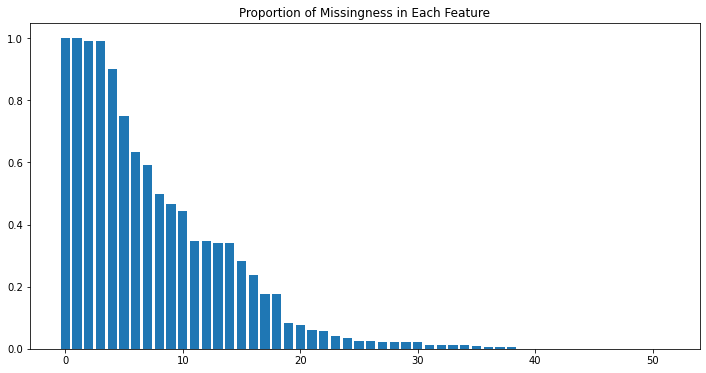

In [52]:
plt.figure(figsize=(12, 6))
plt.bar(x=np.arange(0, len(df.columns)), height = np.sort(df.isna().sum() / len(df))[::-1])
plt.title('Proportion of Missingness in Each Feature')
plt.show()

We see that a number of features are almost entirely missing. These features should be removed from consideration as dropping all rows in which the feature is missing will result in a substantial reduction in our data set's size and imputation methods will likely be wildly inaccurate. Observing the bar chart we see a substantial drop off in the proportion of missingness between the sixth and seventh most missing features. To drop the 6 most missing features we use a threshold of 65%.

In [53]:
df = df.loc[:, df.isna().sum() / len(df) < 0.65]

Now we must determine if the data is Missing Completly at Random (MCAR). If it is we can safetly drop the rows containing missing data and conduct our analysis on the rows which remain. To make this detirmination we first a create a binary column for each feature which denotes missingness. Using our notation from lecture these columns encode the $R_i$.

In [5]:
df_missing = df.copy()

#create the R_i columns
Ri = []
for column in df_missing.columns:
    df_missing[str(column) + '_na'] = pd.isna(df[column]).astype(int)

#remove Ri columns corresponding to non-missing/fully observed features
df_missing = df_missing.loc[:, (df_missing != 0).any(axis=0)]
Ri = df_missing.columns[46:]

Next we look to see if there is a correlation between the country and what data is missing. Since both the country and the $R_i$ are categorical variables this can be done with a hypothesis test known as a $\chi^2$-contigency test. The null hypothesis of this test is $H_0$: the variables are independent. In the below cell we perform 33 such tests, one for every $R_i$.

In [6]:
import scipy.stats as ss

p_vals = []
for col in Ri:
    M = pd.crosstab(df_missing['iso_code'], df_missing[col])
    p_vals.append(ss.chi2_contingency(M)[1])
print(p_vals)

[0.0, 0.0, 0.0, 0.0, 4.2864243497420654e-262, 0.0, 0.0, 2.119028712327211e-289, 5.824784229582191e-288, 0.0, 0.0, 2.768530927737676e-47, 4.558514093853946e-57, 2.1018706060787444e-55, 7.335415174573336e-19, 1.4935869467241454e-19, 1.347144515122251e-301, 3.001463581317831e-45, 3.001463581317831e-45, 3.524780348645179e-298, 3.524780348645179e-298, 3.524780348645179e-298, 2.9254958800787275e-274, 0.0, 0.0, 3.524780348645179e-298, 0.0, 0.0, 0.0, 2.807667089726142e-166, 0.0, 1.4935869467241454e-19, 7.335415174573336e-19]


All of the p-values are extraordinarily small, practically zero. This means that every feature's missingness is correlated with the country. To be more formal we should utilize a Bonferroni Correction for simulatenous inference. Thus, instead of conducting the test at a 95% confidence level which corresponds to $\alpha = 0.05$ we instead use $\alpha = \frac{0.05}{33} = 0.0016.$ However, even with this correction every p-value falls below the 0.0016 threshold.

We are also interested in detirmining if any of the continuous features are correlated with missingness. To make this detirmination we employ a Kruskal-Wallace test which takes in a quantitative and categorigal variable, splits the quantitative variable into groups based on the categorical variable's value and attempts to determine if the medians of the quantitative variables in each group differ significantly from each other. The null hypohtesis is $H_0$: medians of the groups are the same.

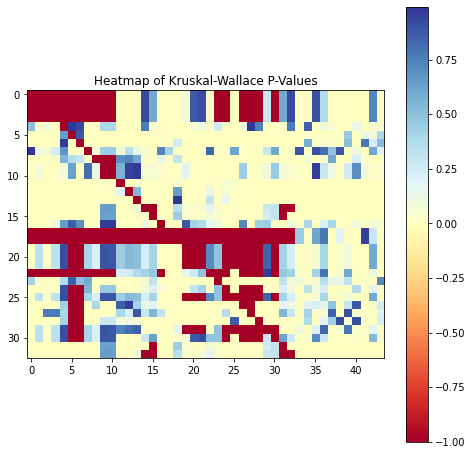

In [7]:
#drop categorical features
df_missing.drop(['iso_code','date'], axis=1, inplace = True)
#columns of quantitative features
quant_cols = df_missing.columns[:44]
#initialize data structure to hold p-values
arr = np.zeros((len(Ri), len(quant_cols)))
for i, missing_col in enumerate(Ri):
    for j, old_col in enumerate(quant_cols):
        #remove rows in which the quantitative predictor is missing
        df_sub = df_missing[df_missing[old_col].notna()]
        #group by the R_i into those rows with 0 and those with 1
        g = df_sub.groupby(missing_col)
        val_list = []
        for val in df_sub[missing_col].unique():
          #get the quantitative column of interest for each group
          val_list.append(g.get_group(val)[old_col])
        #if neither group is empty
        if len(val_list) > 1: arr[i,j] = ss.kruskal(*val_list).pvalue
        else: arr[i,j] = -1

missingness_corr = pd.DataFrame(arr)

plt.figure(figsize=(8, 8))
plt.imshow(missingness_corr, cmap ="RdYlBu")
plt.colorbar()
plt.title('Heatmap of Kruskal-Wallace P-Values')
plt.show()

In the above heat map each cell corresponds to the p-value of a single Kruskal-Wallace test between a quantitative feature and an $R_i$. The dark red cells correspond to p-values of -1 which denote instances where the Kruskal-Wallace test could not be completed because the $R_i$ was always 0 or always 1 when the quantitative feature was present. The pale yellow cells denote near zero p-values of which there are many. These cells denote combinations of quantititave features and $R_i$ which are highly correlated. Thus, through quick visual inspection we can detirmine that there is a lot of correlation between the $R_i$ and observed data in the data set.

Through the above analysis we can firmly conclude that our data is not MCAR and so we cannot drop rows which contain missing data. This is because the data's missingness is highly correlated with the observed data. Instead we will assume for the purposes of our further analysis that our data is MAR and leverage imputation techniques to make educated guesses about the values of the underlying $X_i^{(1)}$

Simple imputation techniques such as filling in missing values with the feature's mean, median, or mode are unlikely to sufficient given the complexity and amount of missingness present in the data set. Feed-forward imputation in which missing data is imputed with the feature's value in the last row it was present could potentially yeild usable results since our data has a time series component. However, such a technique fails to leverage information about the observed data which could have strong predictive capabilities. K-Nearest Neighbors imputation, in which missing data is filled with the data of similar/nearby points was also considered. However, while such a technique does indeed leverage observed data KNN, is not ideal in high dimensional situations such as ours since "all points in high dimensions are lonely," the curse of dimensionality strikes again! Finally, we considered a iterative linear regression imputation approach in which each feature with missing data is fitted with a linear regression model which uses the other features as predicters. This is done iteratively, over many rounds, until convergence. This approach allows us to leverage our observed data while not succumbing to the curse of dimensionality.

The iterative linear regression approach is implmented in the cell below. Note that dummy variables are created for country and month/year to give the imputation model more predictive ability. Furthermore, we use our knowledge about vaccine rollout to make educated desicions about some features. For example, all values for the feature "total_vaccinations_per_hundred" in rows corresponding to dates prior to December, 2020 are manually set to 0. We impute the data set in its entirety and also training and testing sets, being to sure to fit the imputer using the training set prior to imputing the testing set to prevent data leakage. Lastly, because this data will be used in a linear regression model we drop any columns associated with the response to ensure that are predictors are not imputed with information from the response and vice versa.

In [8]:
#remove rows with missing response
df = df[df['new_cases_smoothed_per_million'].notna()]
df = df[df['new_deaths_smoothed_per_million'].notna()]

#set vaccine data for dates prior to December, 2020 to 0
df['date'] = pd.to_datetime(df['date'])
df.loc[df['date'] < pd.Timestamp('2020-12-01 12:00:00'), ['total_vaccinations_per_hundred', 
                                                          'people_vaccinated_per_hundred',
                                                          'people_fully_vaccinated_per_hundred',
                                                          'new_vaccinations_smoothed_per_million',
                                                          'new_people_vaccinated_smoothed_per_hundred',
                                                          'daily_people_vaccinated_per_hundred',
                                                         'daily_vaccinations_per_million']] = 0

#create a column denoting month/year
df['month_yr'] = df['date'].apply(lambda x: x.strftime('%m-%Y'))

#drop columns associated with response
df = df.drop(['total_cases_per_million','total_deaths_per_million','total_tests_per_thousand',
              'positive_rate','tests_per_case','hospital_beds_per_thousand','icu_patients_per_million',
              'hosp_patients_per_million','month_yr','population','reproduction_rate','new_tests_smoothed_per_thousand'], axis = 1)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

#split into a training and testing set
train, test = train_test_split(df, train_size = 0.8, random_state = 42)
df.reset_index(drop=True, inplace = True)
train.reset_index(drop=True, inplace = True)
test.reset_index(drop=True, inplace = True)

#save these columns for later
date = df['date']
iso_code = df['iso_code']
cases = df['new_cases_smoothed_per_million']
deaths = df['new_deaths_smoothed_per_million'] 

train_date = train['date']
train_iso_code = train['iso_code']
train_cases = train['new_cases_smoothed_per_million']
train_deaths = train['new_deaths_smoothed_per_million'] 

test_date = test['date']
test_iso_code = test['iso_code']
test_cases = test['new_cases_smoothed_per_million']
test_deaths = test['new_deaths_smoothed_per_million'] 
                   
#drop response columns
df = df.drop(['new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million'], axis = 1)
train = train.drop(['new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million'], axis = 1)
test = test.drop(['new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million'], axis = 1)

#drop date columns
df.drop('date', axis=1, inplace=True)
train.drop('date', axis=1, inplace=True)
test.drop('date', axis=1, inplace=True)

#create dummy variables for categorical variables
df_dummy = pd.get_dummies(df, drop_first=True)
train_dummy = pd.get_dummies(train, drop_first=True)
test_dummy = pd.get_dummies(test, drop_first=True)

#drop dummy variables that do not appear in both train and test set
test_dummy.drop(list(set(test_dummy.columns.tolist()) - set(train_dummy.columns.tolist())), axis = 1, inplace = True)
train_dummy.drop(list(set(train_dummy.columns.tolist()) - set(test_dummy.columns.tolist())), axis = 1, inplace = True)

#imputed full data set
imputer = IterativeImputer(estimator = BayesianRidge(), max_iter = 10, min_value = df_dummy.min(axis=0), max_value = df_dummy.max(axis=0), random_state=42)
df_imputed_full = pd.DataFrame(imputer.fit_transform(df_dummy))

#imputed train/test split data
imputer_split = IterativeImputer(estimator = BayesianRidge(), max_iter = 10, min_value = train_dummy.min(axis=0), max_value = train_dummy.max(axis=0), random_state=42)
train_imputed_full = pd.DataFrame(imputer_split.fit_transform(train_dummy))
test_imputed_full = pd.DataFrame(imputer_split.transform(test_dummy))

/home/neha/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/neha/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [10]:
df_imputed_full = df_imputed_full.iloc[:,:31]
df_imputed_full.columns = df_dummy.columns[:31]
df_imputed_full['date'] = date
df_imputed_full['date'] = pd.to_datetime(df_imputed_full['date'])
df_imputed_full['iso_code'] = iso_code
df_imputed_full['new_cases_smoothed_per_million'] = cases
df_imputed_full['new_deaths_smoothed_per_million']  = deaths
df_imputed_full['month_yr'] = df_imputed_full['date'].apply(lambda x: x.strftime('%m-%Y'))
df_imputed_full.to_csv(os.path.join(personal_path, 'Data/biweekly_imputed_old_fixed.csv'))

train_imputed_full = train_imputed_full.iloc[:,:31]
train_imputed_full.columns = train_dummy.columns[:31]
train_imputed_full['date'] = train_date
train_imputed_full['date'] = pd.to_datetime(train_imputed_full['date'])
train_imputed_full['iso_code'] = train_iso_code
train_imputed_full['new_cases_smoothed_per_million'] = train_cases
train_imputed_full['new_deaths_smoothed_per_million']  = train_deaths
train_imputed_full['month_yr'] = train_imputed_full['date'].apply(lambda x: x.strftime('%m-%Y'))
train_imputed_full.to_csv(os.path.join(personal_path, 'Data/biweekly_train_imputed_old_fixed.csv'))

test_imputed_full = test_imputed_full.iloc[:,:31]
test_imputed_full.columns = test_dummy.columns[:31]
test_imputed_full['date'] = test_date
test_imputed_full['date'] = pd.to_datetime(test_imputed_full['date'])
test_imputed_full['iso_code'] = test_iso_code
test_imputed_full['new_cases_smoothed_per_million'] = test_cases
test_imputed_full['new_deaths_smoothed_per_million']  = test_deaths
test_imputed_full['month_yr'] = test_imputed_full['date'].apply(lambda x: x.strftime('%m-%Y'))
test_imputed_full.to_csv(os.path.join(personal_path, 'Data/biweekly_test_imputed_old_fixed.csv'))

### Ordinary Least Squares Linear Regression Models

To begin forming our linear regression models we load in our imputed data set.

In [11]:
path_full = os.path.join(personal_path, "Data/biweekly_imputed_old_fixed.csv")
df = pd.read_csv(path_full)

For our first model the reponse will be the number of new Covid cases per million people on a particular day in a particular country. For now we not interested in predicting the reponse of future data points, rather we are interested in direct interpretation of the regression coefficients. Therefore, we forgo splitting the data into a train and test set. 

Prior to imputing we dropped irrelevant/unineteresting features. For example, having the positive rate of Covid tests on a particular day will indeed be useful for predicting the number of new cases, but this relationship is fundamentally obvious. We want to uncover less intutive relationships.

We hope most of the predictor names are sufficiently descriptive. One point of clarification is for the variant predictors such as Alpha, Mu, Delta, etc. correspond to proportion of cases in a specific country on a specific date attributed to each variant. Thus, the sum of the variant data should be 1 for every country on every date.

In [12]:
y = df['new_cases_smoothed_per_million']
X = df.drop(['Unnamed: 0', 'date', 'iso_code','month_yr','new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million'], axis = 1)

Next, we examine the correlation between features in our data set. Recall that in a an Ordinary Least Squares Linear Regression we assume $Y_i = \beta_0 + \beta_1x_1 + \beta_1x_1 +\ldots + \beta_kx_k + ϵ_i$ where we have $k$ features, the n data points are independent, and $\epsilon ~ \sim \mathcal{N}(0, \sigma^2)$. Under these assumptions the associated likelihhod is $\prod_i^n p(\vec{x_i})\cdot \frac{1}{(2\sigma^2\pi)^{\frac{1}{2}}} \cdot exp\{-\frac{(y_i-(\beta_0 + \sum_{j=1}^k\beta_jx_{ij}))^2}{2\sigma^2}\}$ and it can be shown that maximing this expression as a function of $\vec{\beta}$ is equivalent to minimizing $\sum_{i=1}^n(y_i-(\beta_0 + \sum_{j=1}^k\beta_jx_{ij}))^2$ in terms of $\vec{\beta}$. From here it follows that the regression coefficients can solved in closed form as $\hat{\vec{\beta}} = (X^TX)^{-1}X^TY$ where $X$ is our design matrix (matrix of predictors + a column of 1s for an intercept term) and $Y$ is our vector of responses. Note that $\hat{\vec{\beta}}$ depends on $(X^TX)^{-1}$ and that the latter expression will not be invertible if the columns of features are linearly dependent. Thus, if the columns of the design matrix are linearly dependent the OLS estimates for the coefficients cannot be solved for. Furthermore, by noting that $\hat{\vec{\beta}} \sim \mathcal{N}(0, (X^TX)^{-1}\sigma^2)$ we see that large values in $(X^TX)^{-1}$ will cause our coefficient estimates to be highly variable. Thus, we must also be careful to ensure that our design matrix is not near singluar as such a design matrix would yeild abnormally large values in $(X^TX)^{-1}$ and cause our estimates to be highly variable. To avoid this situation we analyze a correlation matrix of our features. Having features that are highly correlated will result in $(X^TX)^{-1}$ being near singular and so if a pair of features is highly correlated we will remove one of them. The plot below visualizes our correlation matrix. We are concerned about off-diagonal cells which are light green/yellow.

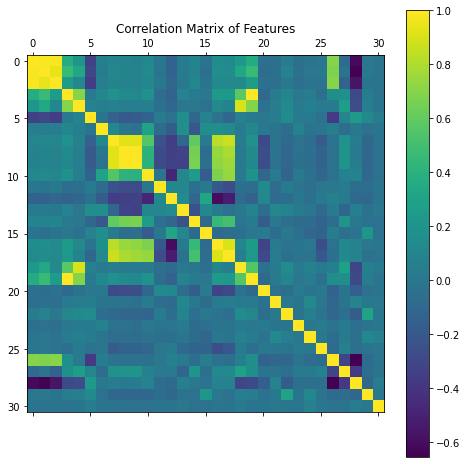

In [13]:
plt.figure(figsize=(8, 8))
plt.matshow(X.corr(), fignum = 1)
plt.colorbar()
plt.title('Correlation Matrix of Features')
plt.show()

We now drop the highly correlated predictors from our design matrix. We use a threshold of 0.8 to identify highly correlated pairs.

In [14]:
X.drop(['non_who','daily_people_vaccinated_per_hundred','people_vaccinated_per_hundred',
        'people_fully_vaccinated_per_hundred','daily_vaccinations_per_million',
        'new_people_vaccinated_smoothed_per_hundred','life_expectancy','aged_70_older',
        'human_development_index'], axis = 1, inplace = True)

We now fit our initial linear regression model. We display some verbose output from the regression below and analyze it in the proceeding cell.

In [15]:
import statsmodels.api as sm

#add a column of ones for the intercept term
X_full = sm.add_constant(X)
est_full = sm.OLS(y, X_full)
est_full_fit = est_full.fit()
print(est_full_fit.summary())

                                  OLS Regression Results                                  
Dep. Variable:     new_cases_smoothed_per_million   R-squared:                       0.150
Model:                                        OLS   Adj. R-squared:                  0.141
Method:                             Least Squares   F-statistic:                     17.20
Date:                            Mon, 13 Dec 2021   Prob (F-statistic):           7.37e-61
Time:                                    00:09:46   Log-Likelihood:                -14432.
No. Observations:                            2164   AIC:                         2.891e+04
Df Residuals:                                2141   BIC:                         2.904e+04
Df Model:                                      22                                         
Covariance Type:                        nonrobust                                         
                                            coef    std err          t      P>|t|      [0.

The first value to consider is the $R^2$ value. This is a measure of goodeness of fit and is defined as $R^2=1-\frac{\sum_{i=1}^n(y_i-\hat{y_i})^2}{\sum_{i=1}^n(y_i-\bar{y})^2}$. Evidently the closer $R^2$ is to 1 the better the model is at explaining the response. We will consider the adjusted $R^2$ value which penalizes for having many predictors. Such a penalty is logical since adding predictors to a linear regression model will only help its explanatory ability even if the added predictor is completly irrelavent. For our model $Adj. R^2 = 0.131$ which is rather low. Such a value can roughly be interpreted as meaning that the predictor variables account for 13.1% of the variability in the response variable. Nonetheless the model is not worthless. The $F-Test$ for overall model utility which has null hypothesis $H_0:$ our model and a model consisting of only an intercept term have the same explanatory capability, has a near zero p-value. Thus, we can conclude that the predictors do indeed have an effect on the response but they do not tell the entire story. We can also examine $t-tests$ for individual predictors. Each such test has the null hypothesis $H_0:$ the coefficient associated with the predictor is 0. Thus, if the p-value of such a test is large the predictor may not have any influence on the response and may be able to be removed without hindering the model. In our model, if we conduct the test at a 95% confidence level, the insignificant predictors are aged 65 older, extreme poverty, cardio vasc death rate, diabetes prevalence, male smokers, Beta, Kappa, Iota, Eta, Lambda, Epsilon and Mu. we now fit a model with these predictors removed and check to see if we can safetly justify their removal.

In [16]:
from statsmodels.stats.anova import anova_lm
X_nested = X.drop(['aged_65_older','extreme_poverty','cardiovasc_death_rate','diabetes_prevalence','male_smokers','Beta','Kappa','Iota','Eta','Lambda','Mu','Epsilon'], axis = 1)
X_nested_const = sm.add_constant(X_nested)
est_nested = sm.OLS(y, X_nested_const)
est_nested_fit = est_nested.fit()
print(anova_lm(est_nested_fit, est_full_fit))

   df_resid           ssr  df_diff       ss_diff         F    Pr(>F)
0    2153.0  7.982698e+07      0.0           NaN       NaN       NaN
1    2141.0  7.864620e+07     12.0  1.180779e+06  2.678713  0.001394


The above output details an $F-Test$ for nested linear regression models. The null hypothesis is $H_0:$ all coeffcients present in the full model but not the nested model are 0. In other words the hypothesis test is detirmining if the nested model accounts for the just as much variance in the reponse as the full model. In our case the p-value is 0.04604 and so we reject the null hypothesis at the 95% confidence level and cannot reduce the model. We try again but this time retaining the Epislon predictor since the associated $t-test$ was nearly significant. We recognize that such a procedure may not be the most mathematically sound, a better approach for model reduction is employed in when constructing Generalized Linear Models later in this section.

In [17]:
from statsmodels.stats.anova import anova_lm
X_nested = X.drop(['aged_65_older','extreme_poverty','cardiovasc_death_rate','diabetes_prevalence','male_smokers','Beta','Kappa','Iota','Eta','Lambda','Mu'], axis = 1)
X_nested_const = sm.add_constant(X_nested)
est_nested = sm.OLS(y, X_nested_const)
est_nested_fit = est_nested.fit()
print(anova_lm(est_nested_fit, est_full_fit))

   df_resid           ssr  df_diff       ss_diff         F    Pr(>F)
0    2152.0  7.972439e+07      0.0           NaN       NaN       NaN
1    2141.0  7.864620e+07     11.0  1.078189e+06  2.668339  0.002103


Noe the p-value associated with model reduction in 0.106 and so we can justfiably reduce the model at the 95% confidence level. We now examine the coefficients of this nested model.

In [18]:
print(est_nested_fit.summary())

                                  OLS Regression Results                                  
Dep. Variable:     new_cases_smoothed_per_million   R-squared:                       0.139
Model:                                        OLS   Adj. R-squared:                  0.134
Method:                             Least Squares   F-statistic:                     31.47
Date:                            Mon, 13 Dec 2021   Prob (F-statistic):           2.35e-62
Time:                                    00:09:46   Log-Likelihood:                -14447.
No. Observations:                            2164   AIC:                         2.892e+04
Df Residuals:                                2152   BIC:                         2.899e+04
Df Model:                                      11                                         
Covariance Type:                        nonrobust                                         
                                            coef    std err          t      P>|t|      [0.

Interpreting regression coefficients can be tricky. One needs to resist the temptation to fit a narraive to explain the why the coefficients take on certain values. For example, strigency_index is a metric developed by Our World in Data, that attempts to quantify how many restrictions a country has put in place to slow the spread of Covid-19. Countries with mask mandates, travel bans, and mandatory quarantines will have a higher strigency index than those countries which do not. The regression coefficient associated with strigency index is 2.86, suggesting that the more restrictions a government puts in place the more Covid-19 spreads. Of course the true relationship is likely that the governments of countries in which there is a COVID-19 outbreak, and thus lots of new cases, are more likely to implement restrictive measures to slow the spread. Other interesting findings are that the only significant variants were Epsilon, Gamma, Delta, and Alpha, all of which have positive coefficients. This could possibly suggest that these variants are more contagious. However, in the case of the Gamma and Epsilon variants the data is limited and so any conclusions should be take with a grain of salt. Another interesting note is that the female smoker predictor was significant but the male smoker predictor was not. We are hesistant to hypothesize why this is the case but perhaps the amount of female smokers in a country is a proxy for the nation's underlying ideology about government interventions. Lastly, it seems counter intuitive that the amont of new vaccinations administered on a day would be posivelty associated with the number of new cases. This may be due to more people being convinced to receive vaccines during particularly bad Covid outbreaks.

We are also interested in directly comparing the magnitide of the effect of each predictor. To do this we standardize the predictors and re-fit the regression model. Note that with the scaled data no intercept term is necessary.

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(np.array(y).reshape(-1,1))
cols = X_nested.columns
X_nested_scaled = pd.DataFrame(scaler.fit_transform(X_nested))
X_nested_scaled.columns = cols
est_nested_scaled = sm.OLS(y_scaled, X_nested_scaled)
est_nested_scaled_fit = est_nested_scaled.fit()
print(est_nested_scaled_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.139
Model:                            OLS   Adj. R-squared (uncentered):              0.134
Method:                 Least Squares   F-statistic:                              31.49
Date:                Mon, 13 Dec 2021   Prob (F-statistic):                    2.18e-62
Time:                        00:09:46   Log-Likelihood:                         -2909.2
No. Observations:                2164   AIC:                                      5840.
Df Residuals:                    2153   BIC:                                      5903.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

From this output we can see that we see that the two non-variant related predictors with greatest positive affect on the number of cases on a given day were strigency index and female smokers. Furthermore, we can now see that the Delta variant seems to be the most contagious.

The last analysis we will perform on this model will be the addition of categorical predictors. These added predictors correspond to the country and the month-year combination corresponding to each row.

In [20]:
X_nested['iso_code'], X_nested['month_year'] = df['iso_code'], df['month_yr']
X_nested_dummy = pd.get_dummies(X_nested, drop_first=True)
X_nested_dummy_const = sm.add_constant(X_nested_dummy)
est_dummy = sm.OLS(y, X_nested_dummy_const)
est_dummy_fit_cases = est_dummy.fit()
print(est_dummy_fit_cases.summary())

                                  OLS Regression Results                                  
Dep. Variable:     new_cases_smoothed_per_million   R-squared:                       0.471
Model:                                        OLS   Adj. R-squared:                  0.436
Method:                             Least Squares   F-statistic:                     13.68
Date:                            Mon, 13 Dec 2021   Prob (F-statistic):          5.00e-197
Time:                                    00:09:46   Log-Likelihood:                -13920.
No. Observations:                            2164   AIC:                         2.811e+04
Df Residuals:                                2031   BIC:                         2.886e+04
Df Model:                                     132                                         
Covariance Type:                        nonrobust                                         
                                            coef    std err          t      P>|t|      [0.

Including information about country and month/year drastically increases the model's explanatory ability. The model has $Adj. R^2 = 0.437$. Observing the p-values associated with the $t-tests$ for these new coeficients reveals two things. First, COVID-19 has affected some countries much more than others. It is evident that there differences between countreies which affect the number of COVID-19 cases which are not present in the data set. Second, the Covid-19 pandemic has increased and decreased in severity with November, 2020 being perhaps the worst month of the pandemic from a perspective of the amount of new cases worldwide.

We now conduct an entirely anaologous procedure, the only difference being that the response variable will now be new deaths smoothed per million rather than cases.

In [21]:
y = df['new_deaths_smoothed_per_million']
#add a column of ones for the intercept term
X_full = sm.add_constant(X)
est_full = sm.OLS(y, X_full)
est_full_fit = est_full.fit()
print(est_full_fit.summary())

                                   OLS Regression Results                                  
Dep. Variable:     new_deaths_smoothed_per_million   R-squared:                       0.293
Model:                                         OLS   Adj. R-squared:                  0.285
Method:                              Least Squares   F-statistic:                     40.26
Date:                             Mon, 13 Dec 2021   Prob (F-statistic):          2.91e-143
Time:                                     00:09:47   Log-Likelihood:                -5503.7
No. Observations:                             2164   AIC:                         1.105e+04
Df Residuals:                                 2141   BIC:                         1.118e+04
Df Model:                                       22                                         
Covariance Type:                         nonrobust                                         
                                            coef    std err          t      P>|t

Compared to the initial regression on new cases the regression on new deaths provides a moderatly better fit. We have $ADJ. R^2 = 0.283$ and a near zero p-value corresponding to the $F-Test$ for overall model utility. Examining the $t-tests$ for individual coefficients we see that the following are insignificant at a $95\%$ confidence level: diabetes prevalence, extreme poverty, Beta, Iota, Eta, and Mu. One interesting finind is that the total number of vaccinations adminitered by a country was not significant in predicting new cases but IS significant in predicting new deaths. This suggests that the vaccines may not be effective at preventing infection but are effective at limiting extreme cases. We now attempt to remove the insignificant predictors.

In [22]:
from statsmodels.stats.anova import anova_lm
X_nested = X.drop(['diabetes_prevalence','Beta','Iota','Eta','Mu','extreme_poverty'], axis = 1)
X_nested_const = sm.add_constant(X_nested)
est_nested = sm.OLS(y, X_nested_const)
est_nested_fit = est_nested.fit()
print(anova_lm(est_nested_fit, est_full_fit))

   df_resid           ssr  df_diff    ss_diff         F    Pr(>F)
0    2147.0  20548.127910      0.0        NaN       NaN       NaN
1    2141.0  20505.084968      6.0  43.042941  0.749041  0.610176


The removal of predictors is again justified by the large p-value of 0.345 in the $F-Test$ for nested linear regression models shown above. We now examine the values of the estimated parameters in the reduced model.

In [23]:
print(est_nested_fit.summary())

                                   OLS Regression Results                                  
Dep. Variable:     new_deaths_smoothed_per_million   R-squared:                       0.291
Model:                                         OLS   Adj. R-squared:                  0.286
Method:                              Least Squares   F-statistic:                     55.12
Date:                             Mon, 13 Dec 2021   Prob (F-statistic):          2.18e-147
Time:                                     00:09:47   Log-Likelihood:                -5506.0
No. Observations:                             2164   AIC:                         1.105e+04
Df Residuals:                                 2147   BIC:                         1.114e+04
Df Model:                                       16                                         
Covariance Type:                         nonrobust                                         
                                            coef    std err          t      P>|t

We see many of the same phenomena which were present in the new cases model such as a positive coefficient associated with the stringency index. One interesting thing to note is that diabetes prevalence is not signficantly associated with new deaths despite diabetes commonly being referred to as a comorbitity. We hypothesize that this may be the case because diabetes is more prevalent in wealthier countries with better healthcare systems. This would also align with the fact that GDP per capita is also negatively associated with new deaths. Lastly, we note that Delta, Alpha, Lambda, Gamma, and Epsilon variants may be more deadly while Kappa may be less deadly though there is limited data for all but the Alpha and Delta variants.

Next we standardize the coefficients to allow for a direct comparison of their magnitude.

In [24]:
scaler = StandardScaler()
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(np.array(y).reshape(-1,1))
cols = X_nested.columns
X_nested_scaled = pd.DataFrame(scaler.fit_transform(X_nested))
X_nested_scaled.columns = cols
est_nested_scaled = sm.OLS(y_scaled, X_nested_scaled)
est_nested_scaled_fit = est_nested_scaled.fit()
print(est_nested_scaled_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.291
Model:                            OLS   Adj. R-squared (uncentered):              0.286
Method:                 Least Squares   F-statistic:                              55.15
Date:                Mon, 13 Dec 2021   Prob (F-statistic):                   1.84e-147
Time:                        00:09:47   Log-Likelihood:                         -2698.2
No. Observations:                2164   AIC:                                      5428.
Df Residuals:                    2148   BIC:                                      5519.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

With the data now standardized we see that the features with the greatest affect on increasing predictions about new deaths are: strigency index and median age. The features with the greatest affect on decreasing predictions about new deaths are: proportion of population older than 65 and total vaccinations per hundred. The seemingly contradictery coefficients associated with median age and aged 65 or older are perplexing. We note that the Lambda variant may be substantially more deadly than others, though the large positive coefficient could also be due to the variant being most prevalent in under-developed countries. Lastly, these regression coefficients support the notion that the more people in a population who receive vaccines the fewer deaths that population will experience.

Finally, we redo the regression and include categorical variables signifying country and month/year.

In [25]:
X_nested['iso_code'], X_nested['month_year'] = df['iso_code'], df['month_yr']
X_nested_dummy = pd.get_dummies(X_nested, drop_first=True)
X_nested_dummy_const = sm.add_constant(X_nested_dummy)
est_dummy = sm.OLS(y, X_nested_dummy_const)
est_dummy_fit_deaths = est_dummy.fit()
print(est_dummy_fit_deaths.summary())

                                   OLS Regression Results                                  
Dep. Variable:     new_deaths_smoothed_per_million   R-squared:                       0.552
Model:                                         OLS   Adj. R-squared:                  0.522
Method:                              Least Squares   F-statistic:                     18.64
Date:                             Mon, 13 Dec 2021   Prob (F-statistic):          9.35e-265
Time:                                     00:09:47   Log-Likelihood:                -5009.9
No. Observations:                             2164   AIC:                         1.029e+04
Df Residuals:                                 2029   BIC:                         1.106e+04
Df Model:                                      134                                         
Covariance Type:                         nonrobust                                         
                                            coef    std err          t      P>|t

Again we see that the including information about countries and month/year greatly improves the model. We now have $Adj. R^2 = 0.527$, meanig that 52.7% of the variance in the response can be explained by the predictors. This again suggests that the pandemic has been worse in some countries than others. Furthermore, it seems as if there remain meaningful differences between countries which are unaccounted for by country-specific quantitative variables in the data set. Finally, we can observe the coefficients for the month/year combinations and note that December, 2020 seems to have been the most deadly month in the pandemic worldwide.

The last piece of analysis we will do concering the OLS Linear Regression models is to check the validity of the assumptions associated with the model. Recall that in addition to assuming that the correct relationship between the predictors and response was linear (inductive bias) we also assumed... 

1.) the observations are independent

2.) the error terms $\epsilon_i$ follow a normal disribution with mean $0$

3.) the error terms $\epsilon_i$ have a constant variance equal to $\sigma^2$

We now check each of these assumptions for both of our models. We will use the models containing dummy variables for the country and month/year to check the validity of the assumptions. Our methods for checking the assumptions rely on the residuals of our model which are actual minus the fitted values, or more formally, $e_i = Y_i-\hat{Y_i}$.

In [26]:
from statsmodels.stats.stattools import durbin_watson
print('Durbin-Watson Test Statistic - Cases Model: ' + str(durbin_watson(est_dummy_fit_cases.resid)))
print('Durbin-Watson Test Statistic - Deaths Model: ' + str(durbin_watson(est_dummy_fit_deaths.resid)))

Durbin-Watson Test Statistic - Cases Model: 0.7852789186985129
Durbin-Watson Test Statistic - Deaths Model: 0.6548652523013568


Above are the test statistics for Durbin-Watson Tests for both of our linear regression models. Durbin-Watson tests are used to detirmine is a sample has autocorrelation/serial correlation. The null hypothesis is $H_0:$ no serial correlation is present. This is one way of detirmining if assumption #1, that are observations are independent holds. The test statistic for the Durbin-Watson test looks like, $\frac{\sum_{i=2}^{N}(e_i-e_{i-1})^2}{\sum_{i=1}^{N}e_i^2}$. A rule of thumb is that a Durbin-Watson test statistic value in the range $[1.5,2.5]$ signals no autocorrelation. Since both of our test statistic fall outside of this range we conclude that our data is serially correlated and thus likely to not be independent. This makes sense since our response is time series data and the number of new cases and new deaths on one day will be dependent on the number of new cases and new deaths on the previous day.

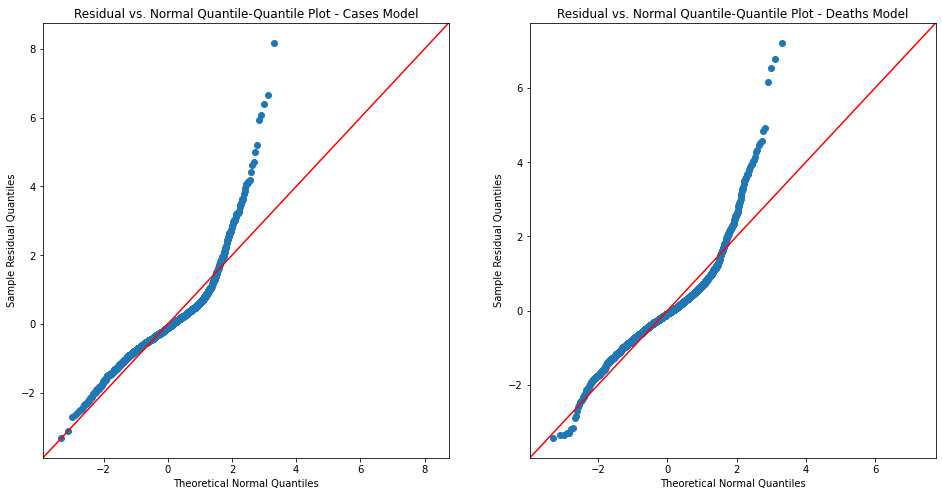

In [27]:
import scipy.stats as stats
figure, ax = plt.subplots(1, 2,figsize=(16,8))
figure.figsize=(8, 8)
sm.qqplot(est_dummy_fit_cases.resid, stats.norm, fit=True, line="45", ax = ax[0])
ax[0].set_title('Residual vs. Normal Quantile-Quantile Plot - Cases Model')
ax[0].set_ylabel('Sample Residual Quantiles')
ax[0].set_xlabel('Theoretical Normal Quantiles')
sm.qqplot(est_dummy_fit_deaths.resid, stats.norm, fit=True, line="45", ax = ax[1])
ax[1].set_title('Residual vs. Normal Quantile-Quantile Plot - Deaths Model')
ax[1].set_ylabel('Sample Residual Quantiles')
ax[1].set_xlabel('Theoretical Normal Quantiles')
plt.show()

The plots above can be used to detirmine the validity of assumption #2. More specifically such Quantile Quantile plots can be used as a visual guide to detirmine if a sample of points follows a given probabaility distribution. QQ-Plots accomplish this by comparing the quantiles of the sampled points with the quantiles of the given distribution. If the sample does indeed follow the distribution the points in the QQ-Plot will closely follow the $45^\circ$ line. Here we are interested in detirmining if the residuals follow a normal distribution. It appears they do not. The points lying above the line suggest that the response variables are skewed right, rather than bell-shaped. This makes sense as the pandemic has impacted some countries to an extraordinary degree.

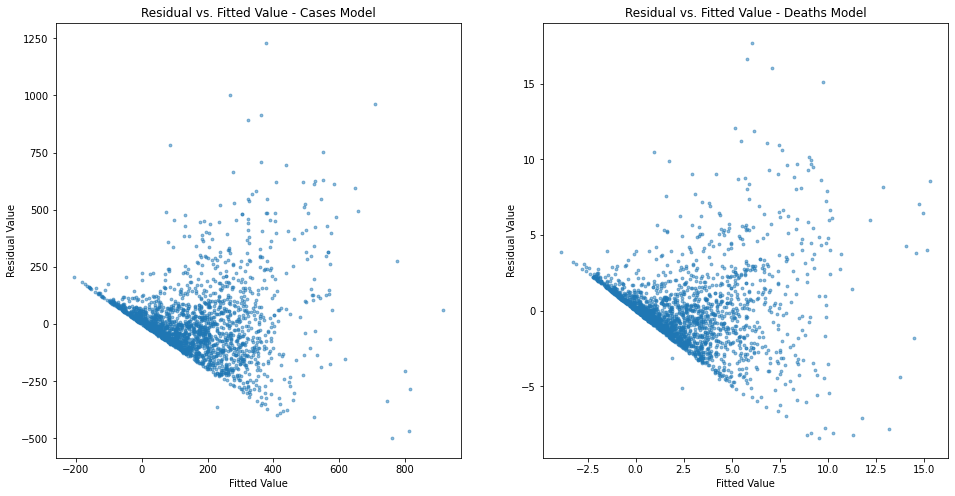

In [28]:
figure, ax = plt.subplots(1, 2,figsize=(16,8))
figure.figsize=(8, 8)
ax[0].scatter(x = est_dummy_fit_cases.fittedvalues, y = est_dummy_fit_cases.resid, s=8, alpha=0.5)
ax[0].set_title('Residual vs. Fitted Value - Cases Model')
ax[0].set_ylabel('Residual Value')
ax[0].set_xlabel('Fitted Value')
ax[1].scatter(x = est_dummy_fit_deaths.fittedvalues, y = est_dummy_fit_deaths.resid, s=8, alpha=0.5)
ax[1].set_title('Residual vs. Fitted Value - Deaths Model')
ax[1].set_ylabel('Residual Value')
ax[1].set_xlabel('Fitted Value')
plt.show()

The above plots can be used to check for the validity of assumption #3. We are primarily concerned about the presence of heteroscedasticity, or non-constant variance, in which case $\epsilon_i$ do not all have the same variance of $\sigma^2$. If the assumption is valid the residuals will look like a random scattering of points that deviate from 0 by approximately the same amount as the fitted value changes. However, the plots above do not show a random scattering, instead we see a predominant straight line, which is odd. We suspect this may be due to the response variable being constant for over some domain of our predictors. For example, just as an unfounded hypothesis, there could be issues with data reliability such that countries report the same amount of new cases/new deaths multiple days in a row.

We see that to varying degrees none of the assumptions associated with linear regression hold. While this does not completely invlidate the model it does mean that any conclusions drawn should be taken with a grain of salt. We now explore generalized linear models (GLM) which make less assumptions to see if we can acheive better results.

### Generalized Linear Models

# Part 2: Recurrent Neural Networks

### Data Preparation

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import math
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

Given the time-stepped granularity of the covid data available, we experiment with recurrent neural networks in order to determine if there's any relation between features collected over a time period and the change in COVID caases over the same time period. We use RNNs to model these temporal relationships. First, we visualize the missing data present in the dataset over each individual date rather than sampled biweekly:

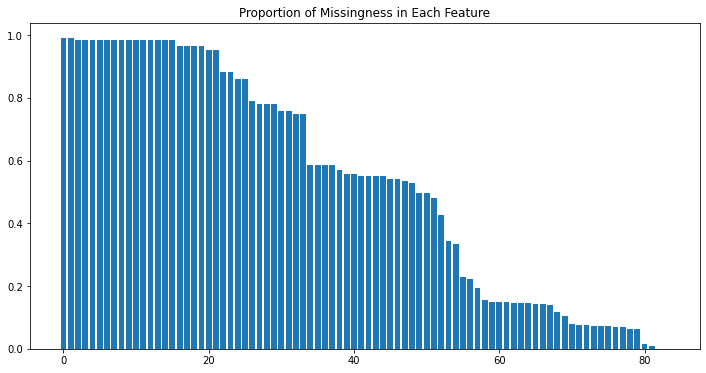

In [55]:
path_covid = os.path.join(personal_path, "Data/full.csv")
df = pd.read_csv(path_covid)
plt.figure(figsize=(12, 6))
plt.bar(x=np.arange(0, len(df.columns)), height = np.sort(df.isna().sum() / len(df))[::-1])
plt.title('Proportion of Missingness in Each Feature')
plt.show()

In [56]:
# look at only columns with less than 65% missing data, for imputation viability
df = df.loc[:, df.isna().sum() / len(df) < 0.65]
df.columns

Index(['iso_code', 'date', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'new_tests',
       'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units',
       'new_vaccinations_smoothed', 'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
     

In [57]:
# prepare datetime, create date_delta float variable, and select relevant features.
df['date'] = pd.to_datetime(df['date'])
df['date_delta'] = (df['date'] - df['date'].min())  / np.timedelta64(1,'D')
df_sub = df[['date_delta','new_tests',
       'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate',
       'new_vaccinations_smoothed', 'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred','daily_people_vaccinated',
       'daily_people_vaccinated_per_hundred', 'daily_vaccinations',
       'daily_vaccinations_per_million']]
y = df[['new_cases_per_million']] #this is the field we want to predict

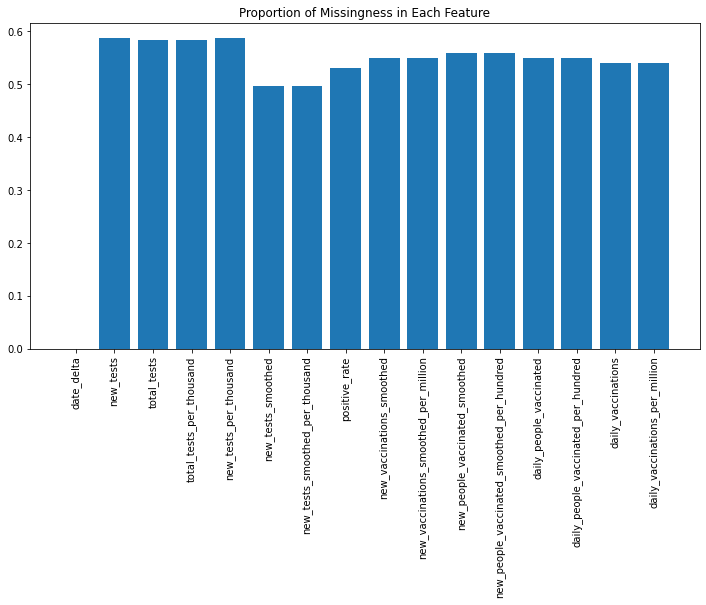

In [36]:
plt.figure(figsize=(12, 6))
plt.bar(x=df_sub.columns, height = df_sub.isna().sum() / len(df_sub))
plt.title('Proportion of Missingness in Each Feature')
plt.xticks(rotation=90)
plt.show()

We now use similar imputation methods from earlier on our features, and fill the small percentage of missing y variables with a simple forward fill. We also create an 80/10/10 training/dev/test split for our time-stepped dataset

In [58]:
train_X, validtest_X, train_y, validtest_y = train_test_split(df_sub, y, train_size = 0.8, random_state = 42, shuffle=False)
valid_X, test_X, valid_y, test_y = train_test_split(validtest_X, validtest_y, train_size = 0.5, random_state = 42, shuffle=False)

imputer_split = IterativeImputer(estimator = BayesianRidge(), max_iter = 30, min_value = df_sub.min(axis=0), max_value = df_sub.max(axis=0), random_state=42)
train_X_imputed = pd.DataFrame(imputer_split.fit_transform(train_X))
valid_X_imputed = pd.DataFrame(imputer_split.transform(valid_X))
test_X_imputed = pd.DataFrame(imputer_split.transform(test_X))
train_X_imputed.columns = df_sub.columns
valid_X_imputed.columns = df_sub.columns
test_X_imputed.columns = df_sub.columns
# is it ok to impute on test with train  data
# use an easy imputer
train_y_imputed = train_y.fillna(method='ffill')
valid_y_imputed = valid_y.fillna(method='ffill')
test_y_imputed = test_y.fillna(method='ffill')

/home/neha/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [41]:
def make_time_stepped(X, y, t):
    X_new = []
    y_new = []
    for i in range(math.floor(len(y) / t)):
        start_date = X.iloc[t*i]['date_delta']
        data_side = X.iloc[t*i:t*i + t]['date_delta']
        check_side = [start_date + j for j in range(t)]
        equality_condition = (data_side == check_side).all()
        if len(X.iloc[t*i:t*i + t]) == t:
            if equality_condition:
                y_new.append(y[t*i:t*i + t].sum()) #delta cases
                X_new.append(X[t*i:t*i + t])
    return X_new, y_new

t = 5
train_X_timed, train_y_timed = make_time_stepped(train_X_imputed, train_y_imputed, t)
valid_X_timed, valid_y_timed = make_time_stepped(valid_X_imputed, valid_y_imputed, t)
test_X_timed, test_y_timed = make_time_stepped(test_X_imputed, test_y_imputed, t)

train_X_timed = np.moveaxis(np.dstack(train_X_timed), 2, 0)
valid_X_timed = np.moveaxis(np.dstack(valid_X_timed), 2, 0)
test_X_timed = np.moveaxis(np.dstack(test_X_timed), 2, 0)

Our RNN code is adapted from: https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

In [59]:
batch_size = 64

# Convert all feature and outcome numpy arrays into tensors
train_features = torch.Tensor(train_X_timed)
train_targets = torch.Tensor(train_y_timed)
val_features = torch.Tensor(valid_X_timed)
val_targets = torch.Tensor(valid_y_timed)
test_features = torch.Tensor(test_X_timed)
test_targets = torch.Tensor(test_y_timed)

# Combine feature and outcome tensors into TensorDatasets
train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

# Load TensorDatasets into DataLoader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
# Extra DataLoader with batch size 1
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [49]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=device).requires_grad_()
        out, h0 = self.rnn(x, h0.detach())
        out = out[:, -1, :] #last hidden goes thru
        out = self.fc(out)
        return out
    
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=device).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=device).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
    }
    return models.get(model.lower())(**model_params)

In [60]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        self.model.train()
        yhat = self.model(x)
        loss = self.loss_fn(y, yhat)
        loss.backward() # backprop 
        self.optimizer.step() # update params
        self.optimizer.zero_grad()
        return loss.item()
    
    def train(self, train_loader, val_loader, model_path, batch_size=64, n_epochs=50, n_features=1):
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)
    
    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()

In [ ]:
input_dim = len(train_X.columns)
output_dim = 1
hidden_dim = 24
layer_dim = 1
dropout = 0.2
n_epochs = 10000 #train for more epochs
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('rnn', model_params)
model = model.to(device)  # Change this line if you want a different model ('rnn')

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, 'models/rnn_start.pt', batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:
input_dim = len(train_X.columns)
output_dim = 1
hidden_dim = 24
layer_dim = 1
dropout = 0.2
n_epochs = 10000 #train for more epochs
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('lstm', model_params)
model = model.to(device)  # Change this line if you want a different model ('rnn')

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, 'models/rnn_start.pt', batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

# Conclusions